# Generating Melakartas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generate intervals
(using method outlined in [wiki](https://en.wikipedia.org/wiki/Melakarta))

In [2]:
spacings = []

for m in range(2):
    for r in range(3):
        for g in range(r, 3):
            for d in range(3):
                for n in range(d, 3):
                    spacings.append([r, g-r, 2-g+m, 1-m, d, n-d, 2-n])
                    
spacings = pd.DataFrame(spacings)
spacings

,0,1,2,3,4,5,6
0,0,0,2,1,0,0,2
1,0,0,2,1,0,1,1
2,0,0,2,1,0,2,0
3,0,0,2,1,1,0,1
4,0,0,2,1,1,1,0
...,...,...,...,...,...,...,...
67,2,0,1,0,0,1,1
68,2,0,1,0,0,2,0
69,2,0,1,0,1,0,1
70,2,0,1,0,1,1,0


So far, this represents the size of the gaps between each note. To get the actual interval in terms of semi-tones we have to add one to each number.

In [3]:
intervals = spacings + 1
intervals

,0,1,2,3,4,5,6
0,1,1,3,2,1,1,3
1,1,1,3,2,1,2,2
2,1,1,3,2,1,3,1
3,1,1,3,2,2,1,2
4,1,1,3,2,2,2,1
...,...,...,...,...,...,...,...
67,3,1,2,1,1,2,2
68,3,1,2,1,1,3,1
69,3,1,2,1,2,1,2
70,3,1,2,1,2,2,1


In [170]:
def get_unbounded_sets(total, n, max_interval=4):
    if n > total:
        return []
    
    if n == total:
        return [[1] * n]
    
    out = []
    for i in range(1, min([total, max_interval]) + 1):
        for s in get_unbounded_sets(total-i, n-1, max_interval=max_interval):
            out.append([i] + s)
    return out

intervals = pd.DataFrame(get_unbounded_sets(16, 7))

# Remove overly "bunched scales"
max_bunching = 2
intervals = intervals[(intervals == 1).sum(axis=1) < max_bunching].reset_index(drop=True)

spacings = intervals - 1 

intervals

,0,1,2,3,4,5,6
0,1,2,2,2,2,3,4
1,1,2,2,2,2,4,3
2,1,2,2,2,3,2,4
3,1,2,2,2,3,3,3
4,1,2,2,2,3,4,2
...,...,...,...,...,...,...,...
373,4,3,1,2,2,2,2
374,4,3,2,1,2,2,2
375,4,3,2,2,1,2,2
376,4,3,2,2,2,1,2


If we want the actual tones being represented (e.g. the 7th tone of the 12 tone scale) then we aggregate the intervals and shift them to be relative to the first note.

In [4]:
aggregated_intervals = intervals.cumsum(axis=1)

# By summing the intervals we go to the octave and lose the root, therefore we have to drop the last column and add zeros
aggregated_intervals.iloc[:, 1:] = aggregated_intervals.iloc[:, :-1].values
aggregated_intervals.iloc[:, 0] = 0
tones = aggregated_intervals
tones

,0,1,2,3,4,5,6
0,0,1,2,5,7,8,9
1,0,1,2,5,7,8,10
2,0,1,2,5,7,8,11
3,0,1,2,5,7,9,10
4,0,1,2,5,7,9,11
...,...,...,...,...,...,...,...
67,0,3,4,6,7,8,10
68,0,3,4,6,7,8,11
69,0,3,4,6,7,9,10
70,0,3,4,6,7,9,11


#### Can also represent in binary

Where each one indicates that the tone of 12 TET is included

In [5]:
def to_binary(spacing):
    out = []
    for i in spacing:
        out.append(1)
        out.extend([0] * i)
    return pd.Series(out)

In [6]:
binary = spacings.apply(to_binary, axis=1)
binary

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,1,1,0,0,1,0,1,1,1,0,0
1,1,1,1,0,0,1,0,1,1,0,1,0
2,1,1,1,0,0,1,0,1,1,0,0,1
3,1,1,1,0,0,1,0,1,0,1,1,0
4,1,1,1,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,0,0,1,1,0,1,1,1,0,1,0
68,1,0,0,1,1,0,1,1,1,0,0,1
69,1,0,0,1,1,0,1,1,0,1,1,0
70,1,0,0,1,1,0,1,1,0,1,0,1


Which allows us to see the pattern more clearly. Each column is a melakarta, and the black is when that tone is included.

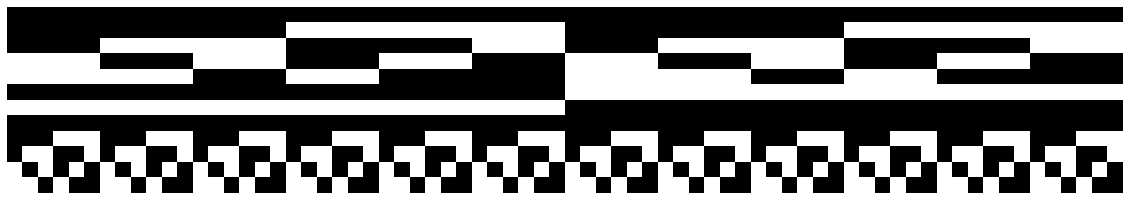

In [7]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(binary.T, cmap='Greys')

## Find parent melakartas

In [8]:
parents = []
modes = []
parent_sets = []
new_parent = False

for idx, mela in intervals.iterrows():
    parent_idx = None
    rotation = None
    for i in range(len(mela)):
        rolled_mela = list(np.roll(mela, i))
        already_parent = rolled_mela in parents
        if already_parent:
            parent_idx = parents.index(rolled_mela)
            rotation = i

    if parent_idx is None:
        parents.append(mela.tolist())
        modes.append(0)
        parent_sets.append([idx])
    
    else:
        parent_sets[parent_idx].append(idx)
        modes.append(rotation)

modes = pd.Series(modes)

parent_sets = pd.Series(parent_sets)

# Sort by number of members in parent set
parent_sets = parent_sets.sort_values(key=lambda s: s.apply(len), ascending=False).reset_index(drop=True)
parent_sets

0     [7, 19, 21, 27, 28, 64]
1             [8, 34, 55, 65]
2             [9, 22, 25, 63]
3            [13, 20, 57, 70]
4                [29, 33, 43]
5                 [1, 18, 52]
6                 [2, 53, 54]
7                 [6, 16, 62]
8                [14, 56, 71]
9                [15, 26, 58]
10                   [23, 31]
11                    [3, 24]
12                    [4, 60]
13                   [10, 61]
14                   [12, 68]
15                   [17, 42]
16                    [0, 50]
17                   [45, 69]
18                   [32, 59]
19                   [35, 44]
20                       [30]
21                       [51]
22                       [49]
23                       [48]
24                       [47]
25                        [5]
26                       [46]
27                       [40]
28                       [41]
29                       [66]
30                       [39]
31                       [11]
32                       [38]
33        

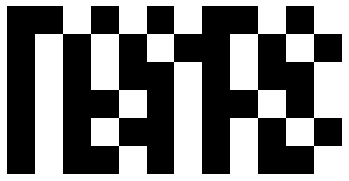

In [9]:
members = parent_sets.iloc[0]
data = binary.iloc[members]

# Work out what mode of the first melakarta the others are, and sort by that position
# (so that the image cycles in the same direction)
set_modes = modes.iloc[members].sort_values()
data

plt.axis('off')
plt.imshow(data.loc[set_modes.index], cmap='Greys')

## Comparing melakartas by interval distribution

In [10]:
interval_counts = intervals.apply(lambda s: s.value_counts(), axis=1).fillna(0).astype(int)

In [11]:
pd.Series(interval_counts.groupby(interval_counts.columns.tolist()).groups).apply(list)

2  5  0  0       [7, 9, 10, 19, 21, 22, 25, 27, 28, 61, 63, 64]
3  3  1  0    [1, 3, 4, 6, 8, 11, 13, 15, 16, 18, 20, 23, 24...
4  1  2  0    [0, 2, 5, 12, 14, 17, 30, 32, 35, 42, 44, 47, ...
   2  0  1                                         [37, 39, 40]
5  0  1  1                                         [36, 38, 41]
dtype: object

## Generating Chords

Chords are simply pairs of intervals. We take basic chords of order *n* by extracting *n* lots of every other interval

In [12]:
order=4
step=2

def get_chord_makeup(scale_intervals):
    modes = (np.roll(scale_intervals, i) for i in range(len(scale_intervals)))
    chords = [[mode[idx*step:(idx+1)*step].sum() for idx in range(order)] for mode in modes]
    return pd.Series(chords)

In [13]:
s = intervals.iloc[0]

CHORD_STEP = 2
MAX_CHORD_SIZE = 4

chordal_composition = [s[CHORD_STEP*idx:CHORD_STEP*(idx+1)].sum() for idx in range(MAX_CHORD_SIZE)]
chordal_composition

[2, 5, 2, 3]

In [14]:
all_melakarta_chords = intervals.apply(get_chord_makeup, axis=1)
all_melakarta_chords

,0,1,2,3,4,5,6
0,"[2, 5, 2, 3]","[4, 4, 3, 1]","[4, 2, 5, 1]","[2, 4, 4, 2]","[3, 4, 2, 3]","[5, 2, 4, 1]","[4, 3, 4, 1]"
1,"[2, 5, 3, 2]","[3, 4, 3, 2]","[4, 2, 5, 1]","[3, 3, 4, 2]","[3, 4, 2, 3]","[5, 3, 3, 1]","[4, 3, 4, 1]"
2,"[2, 5, 4, 1]","[2, 4, 3, 3]","[4, 2, 5, 1]","[4, 2, 4, 2]","[3, 4, 2, 3]","[5, 4, 2, 1]","[4, 3, 4, 1]"
3,"[2, 5, 3, 2]","[3, 4, 4, 1]","[3, 2, 5, 2]","[3, 3, 4, 2]","[4, 3, 2, 3]","[5, 3, 3, 1]","[4, 4, 3, 1]"
4,"[2, 5, 4, 1]","[2, 4, 4, 2]","[3, 2, 5, 2]","[4, 2, 4, 2]","[4, 3, 2, 3]","[5, 4, 2, 1]","[4, 4, 3, 1]"
...,...,...,...,...,...,...,...
67,"[4, 3, 3, 2]","[5, 3, 2, 2]","[4, 4, 3, 1]","[3, 5, 3, 1]","[2, 4, 4, 2]","[3, 3, 5, 1]","[3, 2, 4, 3]"
68,"[4, 3, 4, 1]","[4, 3, 2, 3]","[4, 4, 3, 1]","[4, 4, 3, 1]","[2, 4, 4, 2]","[3, 4, 4, 1]","[3, 2, 4, 3]"
69,"[4, 3, 3, 2]","[5, 3, 3, 1]","[3, 4, 3, 2]","[3, 5, 3, 1]","[3, 3, 4, 2]","[3, 3, 5, 1]","[3, 3, 3, 3]"
70,"[4, 3, 4, 1]","[4, 3, 3, 2]","[3, 4, 3, 2]","[4, 4, 3, 1]","[3, 3, 4, 2]","[3, 4, 4, 1]","[3, 3, 3, 3]"


In [15]:
triads = all_melakarta_chords.apply(lambda chords: chords.apply(lambda chord: chord[:2]), axis=1)
triads

,0,1,2,3,4,5,6
0,"[2, 5]","[4, 4]","[4, 2]","[2, 4]","[3, 4]","[5, 2]","[4, 3]"
1,"[2, 5]","[3, 4]","[4, 2]","[3, 3]","[3, 4]","[5, 3]","[4, 3]"
2,"[2, 5]","[2, 4]","[4, 2]","[4, 2]","[3, 4]","[5, 4]","[4, 3]"
3,"[2, 5]","[3, 4]","[3, 2]","[3, 3]","[4, 3]","[5, 3]","[4, 4]"
4,"[2, 5]","[2, 4]","[3, 2]","[4, 2]","[4, 3]","[5, 4]","[4, 4]"
...,...,...,...,...,...,...,...
67,"[4, 3]","[5, 3]","[4, 4]","[3, 5]","[2, 4]","[3, 3]","[3, 2]"
68,"[4, 3]","[4, 3]","[4, 4]","[4, 4]","[2, 4]","[3, 4]","[3, 2]"
69,"[4, 3]","[5, 3]","[3, 4]","[3, 5]","[3, 3]","[3, 3]","[3, 3]"
70,"[4, 3]","[4, 3]","[3, 4]","[4, 4]","[3, 3]","[3, 4]","[3, 3]"


In [16]:
chord_name_map = {
    "[4, 3]": 'MAJ',
    "[3, 4]": 'MIN',
    "[4, 4]": 'AUG',
    "[3, 3]": 'DIM',
}

named_chords = triads.applymap(lambda c: chord_name_map.get(str(c), None))
named_chords

,0,1,2,3,4,5,6
0,None,AUG,None,None,MIN,None,MAJ
1,None,MIN,None,DIM,MIN,None,MAJ
2,None,None,None,None,MIN,None,MAJ
3,None,MIN,None,DIM,MAJ,None,AUG
4,None,None,None,None,MAJ,None,AUG
...,...,...,...,...,...,...,...
67,MAJ,None,AUG,None,None,DIM,None
68,MAJ,MAJ,AUG,AUG,None,MIN,None
69,MAJ,None,MIN,None,DIM,DIM,DIM
70,MAJ,MAJ,MIN,AUG,DIM,MIN,DIM


In [17]:
get_chord_counts = lambda chords: chords.value_counts(dropna=True)

<AxesSubplot:title={'center':'Chord counts per melakarta'}>

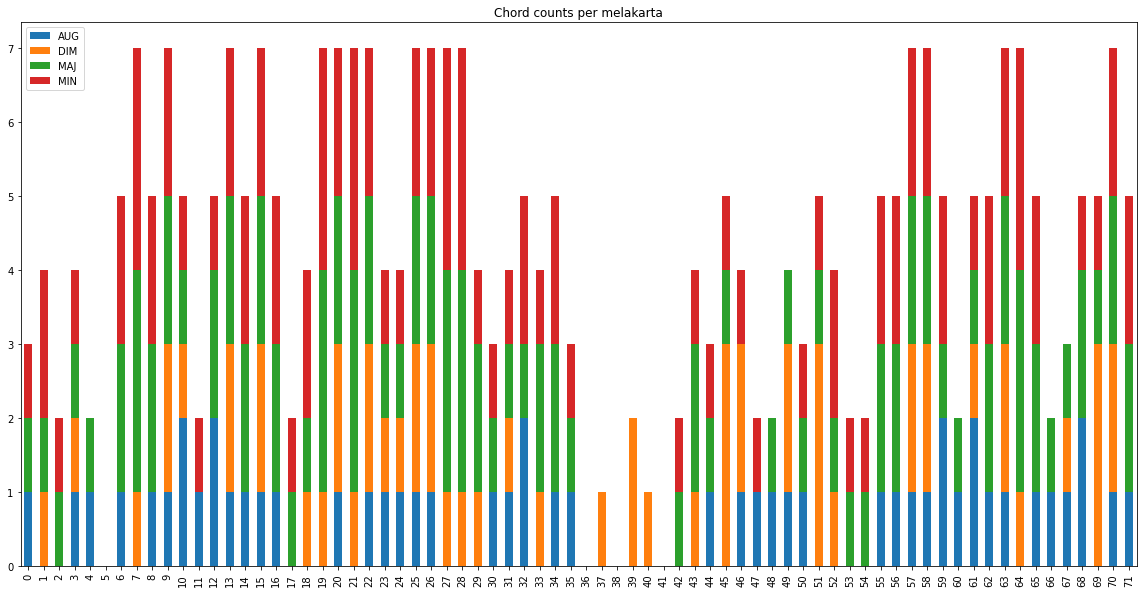

In [27]:
plt.figure(figsize=(20, 10))
plt.title('Chord counts per melakarta')
# View all counts
named_chords.apply(get_chord_counts, axis=1).plot(kind='bar', stacked=True, ax=plt.gca())

<AxesSubplot:title={'center':'Chord counts per parent melakarta'}>

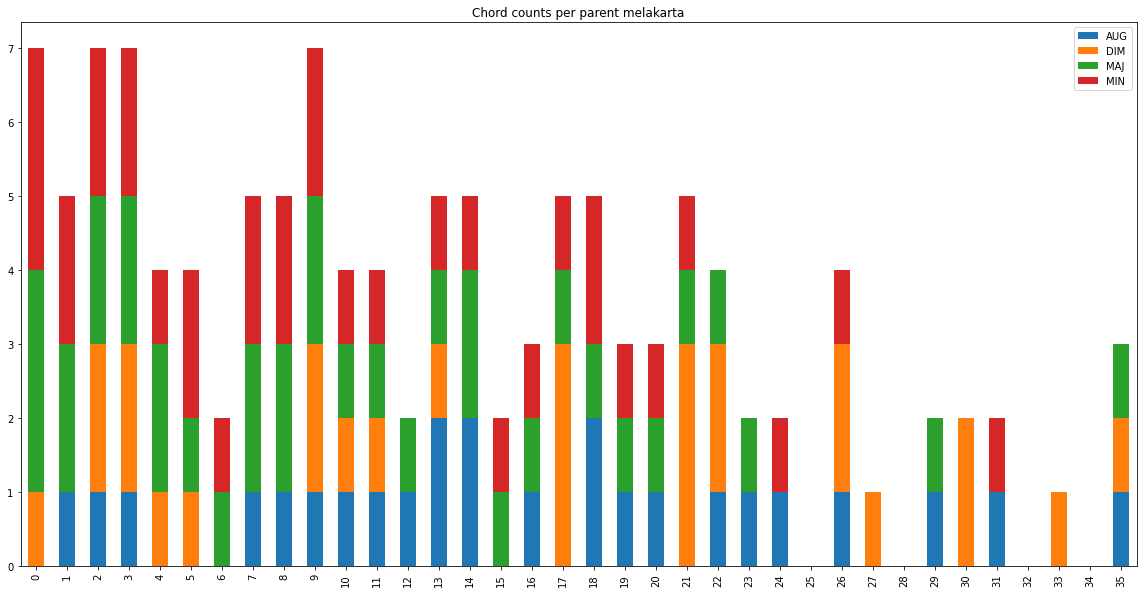

In [26]:
# View counts for parent melas
parent_heads = parent_sets.apply(lambda s: s[0])
plt.figure(figsize=(20, 10))
plt.title('Chord counts per parent melakarta')
named_chords.iloc[parent_heads].reset_index(drop=True).apply(get_chord_counts, axis=1).plot(kind='bar', stacked=True, ax=plt.gca())

## Load meta-data from csv

In [30]:
mela_data = pd.read_csv('./melakarta-data-mini.csv')

In [31]:
chakra_data = pd.read_csv('./chakra-data.csv')

In [32]:
mela_data

,Melakarta ID,Chakra ID,Name
0,1,1,Kanakangi
1,2,1,Ratnangi
2,3,1,Ganamurti
3,4,1,Vanaspati
4,5,1,Manavati
...,...,...,...
67,68,12,Jyoti swarupini
68,69,12,Dhatuvardani
69,70,12,Nāsikabhushini
70,71,12,Kōsalam


In [29]:
chakra_data

,Chakra ID,Chakra Name
0,1,Indu Chakra
1,2,Netra Chakra
2,3,Agni Chakra
3,4,Veda Chakra
4,5,Bana Chakra
5,6,Rutu Chakra
6,7,Rishi Chakra
7,8,Vasu Chakra
8,9,Brahma Chakra
9,10,Disi Chakra


In [34]:
meta_data = mela_data.merge(chakra_data, on='Chakra ID')
meta_data

,Melakarta ID,Chakra ID,Name,Chakra Name
0,1,1,Kanakangi,Indu Chakra
1,2,1,Ratnangi,Indu Chakra
2,3,1,Ganamurti,Indu Chakra
3,4,1,Vanaspati,Indu Chakra
4,5,1,Manavati,Indu Chakra
...,...,...,...,...
67,68,12,Jyoti swarupini,Aditya Chakra
68,69,12,Dhatuvardani,Aditya Chakra
69,70,12,Nāsikabhushini,Aditya Chakra
70,71,12,Kōsalam,Aditya Chakra


## Exports

In [21]:
intervals.to_json('react-app/src/intervals.json', orient='values')

In [22]:
triads.to_json('react-app/src/triads.json', orient='values')

In [23]:
binary.to_json('react-app/src/binary.json', orient='values')

In [24]:
parent_sets.to_json('react-app/src/parent_sets.json', orient='values')

In [39]:
meta_data.to_json('react-app/src/mela_meta.json', orient='records')